[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/keisen/tf-keras-vis/blob/master/examples/visualize_dense_layer.ipynb)

When you haven't yet installed `tf-keras-vis` in your environment, please run the cell below.

In [ ]:
# !pip install --upgrade pip
# !pip install --upgrade tf-keras-vis tensorflow matplotlib

(Please remove comment-out in the cell above when you want to install essential libraries to run tf-keras-vis.)

# Visualizing Dense layer using ActivationMaximization

### Load libraries

In [1]:
%reload_ext autoreload
%autoreload 2

import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

import tensorflow as tf
from tf_keras_vis.utils import num_of_gpus

_, gpus = num_of_gpus()
print('Tensorflow recognized {} GPUs'.format(gpus))

Tensorflow recognized 1 GPUs


### Load tf.keras.Model

This tutorial use VGG16 model in tf.keras but if you want to use other tf.keras.Models, you can do so by modifying section below.

In [2]:
from tensorflow.keras.applications.vgg16 import VGG16 as Model

# Load model
model = Model(weights='imagenet', include_top=True)
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

## Visualizing a specific output category

### Define a function to modify the model

First, when the softmax activation function is applied to the last layer of model, it may obstruct ActivationMaximization, so you need to replace the function to a linear function. Here, we will do so using `model_modifier`.

In [3]:
def model_modifier(cloned_model):
    cloned_model.layers[-1].activation = tf.keras.activations.linear
    return cloned_model

### Create ActivationMaximization Instnace

When `clone` argument is True(default), the `model` will be cloned, so the `model` instance will be NOT modified, but it may take a while.
Here, because it does NOT need to do so, setting False.

In [4]:
from tf_keras_vis.activation_maximization import ActivationMaximization

activation_maximization = ActivationMaximization(model,
                                                 model_modifier,
                                                 clone=False)

### Define Score function

You MUST define `score` function that return arbitrary category value. Here, we try to visualize a category as defined No.20 (ouzel) of imagenet.

In [5]:
from tf_keras_vis.utils.scores import CategoricalScore

score = CategoricalScore(20)

# Instead of CategoricalScore function object, you can define the scratch function such as below:
def score_function(output):
    # The `output` variable refer to the output of the model,
    # so, in this case, `output` shape is `(3, 1000)` i.e., (samples, classes).
    return output[:, 20]

### Visualize

ActivationMaximization will maximize the model output value that is computed by the score function. Here, we try to visualize a convolutional filter.

Steps: 100	Losses: [[142.9811248779297]],	Regularizations: [('TotalVariation2D', [11.315330505371094]), ('Norm', [0.33535242080688477])]
Steps: 200	Losses: [[162.45785522460938]],	Regularizations: [('TotalVariation2D', [11.44835090637207]), ('Norm', [0.3421967923641205])]


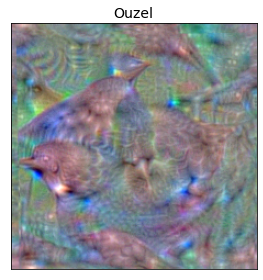

CPU times: user 8.94 s, sys: 1.12 s, total: 10.1 s
Wall time: 9.44 s


In [6]:
%%time
from tf_keras_vis.activation_maximization.callbacks import PrintLogger

activations = activation_maximization(score,
                                      callbacks=[PrintLogger(interval=100)])

subplot_args = { 'nrows': 1, 'ncols': 1, 'figsize': (4, 4),
                 'subplot_kw': {'xticks': [], 'yticks': []} }
f, ax = plt.subplots(**subplot_args)
ax.imshow(activations[0])
ax.set_title('Ouzel', fontsize=14)
plt.tight_layout()
plt.show()

## Visualizing specific output categories

Then, let's visualize multiple categories at once!

### Define Loss function

You MUST define loss function that return arbitrary category values. Here, we will visualize categories as defined No.1 (Goldfish), No.294 (Bear) and No.413 (Assault rifle) of imagenet.

In [7]:
from tf_keras_vis.utils.scores import CategoricalScore

image_titles = ['Goldfish', 'Bear', 'Assault rifle']
scores = CategoricalScore([1, 294, 413])

### Create SeedInput values

And then, beforehand, you MUST create seed-input value. In default, when visualizing a specific output category, tf-keras-vis automatically generate seed-input to visualize a image. When visualizing multiple output categories, you MUST manually create seed-inputs whose samples-dim is as many as the number of the filters you want to generate.

In [8]:
# Create seed inputs whose shape is (samples, height, width, channels).

seed_input = tf.random.uniform((3, 224, 224, 3), 0, 255)

### Visualize

Here, we will visualize 3 images while `steps` option is to be 512 to get clear images.

Steps: 100	Losses: [[198.66973876953125, 116.57514190673828, 119.57063293457031]],	Regularizations: [('TotalVariation2D', [3.7793169021606445, 3.6790239810943604, 3.977771759033203]), ('Norm', [0.34215977787971497, 0.3343886733055115, 0.3391564190387726])]
Steps: 200	Losses: [[296.06524658203125, 191.5362548828125, 121.118896484375]],	Regularizations: [('TotalVariation2D', [4.182602405548096, 3.9482555389404297, 4.149129867553711]), ('Norm', [0.35338976979255676, 0.33910617232322693, 0.34608203172683716])]
Steps: 300	Losses: [[381.5053405761719, 240.41087341308594, 180.0564422607422]],	Regularizations: [('TotalVariation2D', [4.325163841247559, 4.033021450042725, 4.240230083465576]), ('Norm', [0.36413830518722534, 0.34710919857025146, 0.35498467087745667])]
Steps: 400	Losses: [[384.2727966308594, 264.2237548828125, 174.791015625]],	Regularizations: [('TotalVariation2D', [4.776803493499756, 4.4410576820373535, 4.664165019989014]), ('Norm', [0.3776719868183136, 0.355136901140213, 0.364321

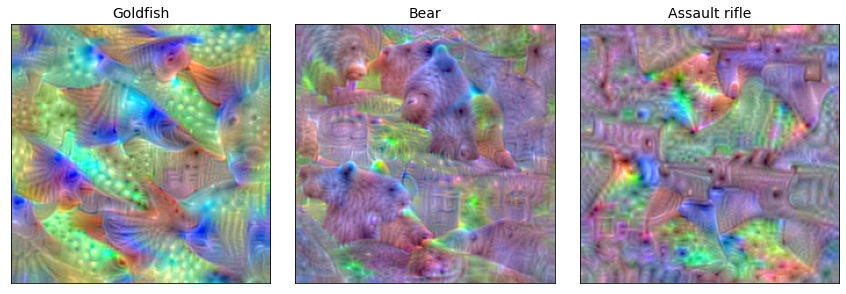

CPU times: user 28.5 s, sys: 331 ms, total: 28.8 s
Wall time: 32.5 s


In [9]:
%%time

# Generate max activation
activations = activation_maximization(scores,
                                      seed_input=seed_input,
                                      steps=512,
                                      callbacks=[ PrintLogger(interval=100) ])

# Render
subplot_args = { 'nrows': 1, 'ncols': 3, 'figsize': (12, 4),
                 'subplot_kw': {'xticks': [], 'yticks': []} }
f, ax = plt.subplots(**subplot_args)
for i, title in enumerate(image_titles):
    ax[i].set_title(title, fontsize=14)
    ax[i].imshow(activations[i])
plt.tight_layout()
plt.savefig('images/visualize-dense-layer')
plt.show()